In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/utilization.csv")
df['PRB'] = df['DL_PRB_UTIL_NUM']/df["DL_PRB_UTIL_DENOM"]*100

<Axes: >

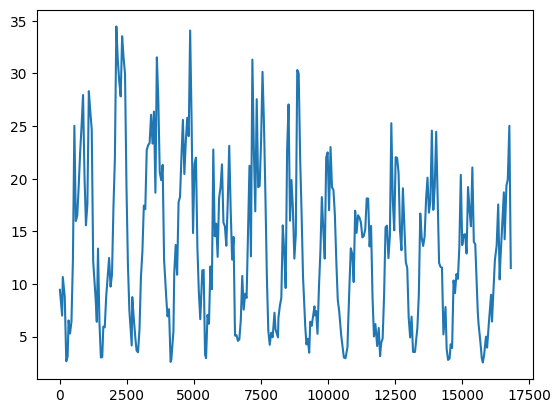

In [3]:
# single cell 
df_single = df[df['cellobject'] == "1011A-CMM-21"]
df_single['PRB'].plot()

In [4]:
df_single = df_single.copy(deep=True)
df_single

,datetime,cellobject,DL_PRB_UTIL_NUM,DL_PRB_UTIL_DENOM,site,sector,sitesector,sitebeam,beam,PRB
0,2024_07_11_00_00,1011A-CMM-21,9.4440,99.9999,1011A,Sector 1,1011A S1,1011A Beam 1,1,9.444009
83,2024_07_11_01_00,1011A-CMM-21,6.9898,99.9998,1011A,Sector 1,1011A S1,1011A Beam 1,1,6.989814
108,2024_07_11_02_00,1011A-CMM-21,10.6616,99.9999,1011A,Sector 1,1011A S1,1011A Beam 1,1,10.661611
180,2024_07_11_03_00,1011A-CMM-21,8.8336,99.9999,1011A,Sector 1,1011A S1,1011A Beam 1,1,8.833609
238,2024_07_11_04_00,1011A-CMM-21,2.6551,99.9999,1011A,Sector 1,1011A S1,1011A Beam 1,1,2.655103
...,...,...,...,...,...,...,...,...,...,...
16594,2024_07_23_19_00,1011A-CMM-21,14.2455,99.9999,1011A,Sector 1,1011A S1,1011A Beam 1,1,14.245514
16662,2024_07_23_20_00,1011A-CMM-21,19.3614,99.9998,1011A,Sector 1,1011A S1,1011A Beam 1,1,19.361439
16712,2024_07_23_21_00,1011A-CMM-21,19.9256,99.9999,1011A,Sector 1,1011A S1,1011A Beam 1,1,19.925620
16770,2024_07_23_22_00,1011A-CMM-21,25.0218,99.9999,1011A,Sector 1,1011A S1,1011A Beam 1,1,25.021825


In [5]:
# time format is string with format YYYY_MM_DD_HH_mm 
# df_single['datetime'] = df_single['datetime'].str.replace("_", "-")
df_single.index = pd.to_datetime(df_single['datetime'] , format='%Y_%m_%d_%H_%M')

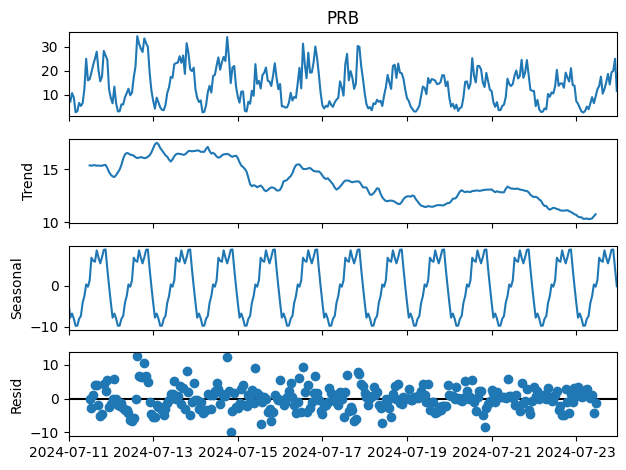

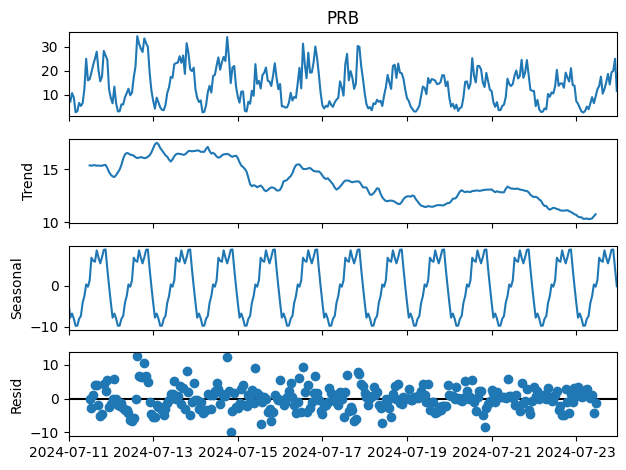

In [6]:
result = seasonal_decompose(df_single['PRB'], model="additive")
result.plot()

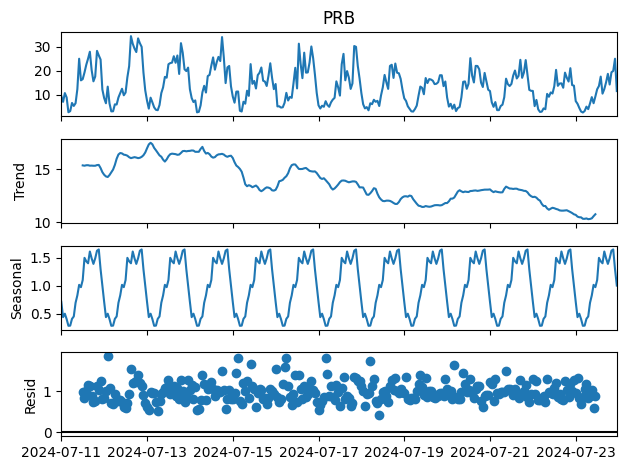

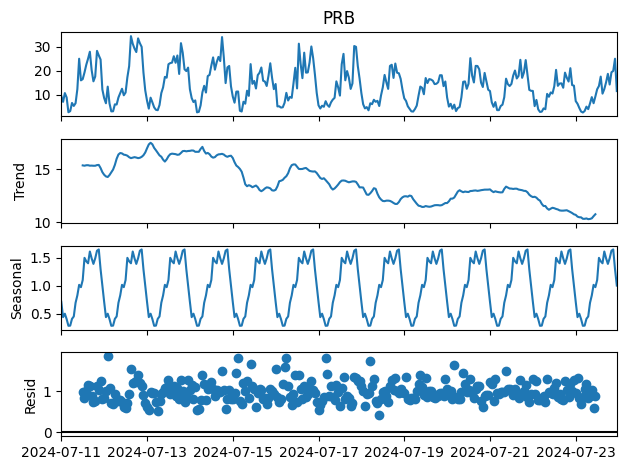

In [9]:
result = seasonal_decompose(df_single['PRB'], model="multiplicative")
result.plot()

In [19]:

result.trend.dropna().values

array([15.38053991, 15.35022325, 15.39421204, 15.3986387 , 15.35425981,
       15.36056828, 15.34720608, 15.3472252 , 15.40950877, 15.42593172,
       15.13084128, 14.73938931, 14.49266212, 14.33353973, 14.27907317,
       14.46288341, 14.72853478, 14.98581863, 15.42843352, 16.01574003,
       16.41447109, 16.55524147, 16.51758727, 16.39859757, 16.36932861,
       16.30025545, 16.15743308, 16.07088967, 16.11526022, 16.16288097,
       16.12484937, 16.0699302 , 16.10414451, 16.19158196, 16.34425753,
       16.60115506, 17.00111004, 17.37147293, 17.52542424, 17.38100692,
       17.04028042, 16.81405288, 16.56315049, 16.33059401, 16.2050543 ,
       15.92641695, 15.74312761, 15.9525174 , 16.24968228, 16.44155748,
       16.4958367 , 16.47434918, 16.44756587, 16.38648878, 16.41106797,
       16.56344312, 16.73678108, 16.75453551, 16.71601668, 16.74702678,
       16.75886506, 16.79644907, 16.78486684, 16.67039223, 16.66855732,
       16.67115838, 16.94378518, 17.13951038, 16.75045791, 16.50

In [55]:
residual = result.resid.dropna()
residual_value = residual.values.reshape(-1, 1)

In [57]:
from sklearn.ensemble import IsolationForest

# Fit the Isolation Forest model
model = IsolationForest(contamination=0.01)
model.fit(residual_value)

IsolationForest(contamination=0.01)

In [58]:
anomaly = model.predict(residual_value)

In [60]:
anomaly_index = residual[anomaly == -1].index

In [61]:
anomaly_index

DatetimeIndex(['2024-07-12 15:00:00', '2024-07-14 18:00:00',
               '2024-07-14 20:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

<Axes: xlabel='datetime'>

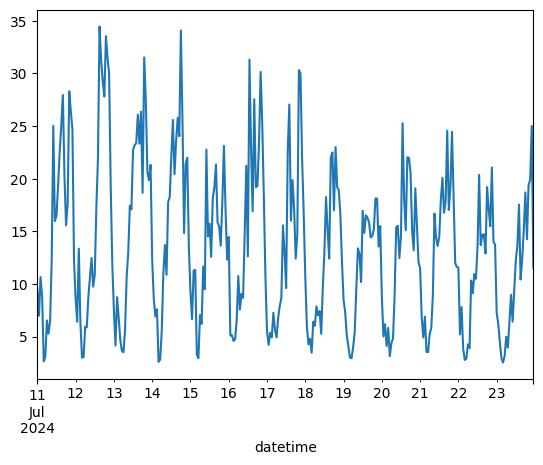

In [64]:
df_single['PRB'].plot()

In [118]:
def visual_anormaly_range(decomposition , series , contamination=0.1):
    residual = decomposition.resid.dropna()
    residual_value = residual.values.reshape(-1, 1)
    
    model = IsolationForest(contamination=contamination)
    model.fit(residual_value)
    
    anomaly = model.predict(residual_value)
    anomaly_index = residual[anomaly == -1].index
    
    plt.figure()
    plt.plot(series.index , series.values)
    
    for i in anomaly_index:
        plt.axvline(i, color='r', linestyle='--', lw=1)
        
    plt.show()

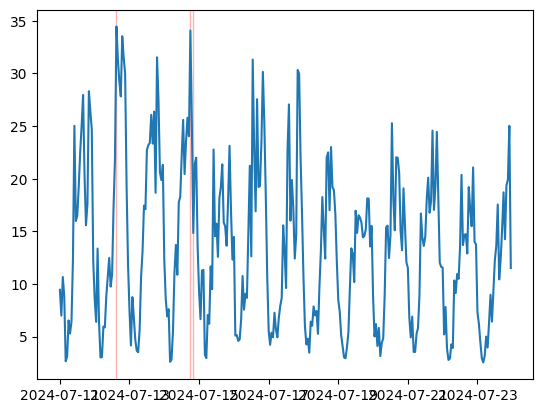

In [67]:
plt.figure()
plt.plot(df_single.index , df_single['PRB'] , label="DL PRB Utilization")

for i in anomaly_index:
    #plt.axvline(i, color='r', linestyle='--', lw=2)
    plt.axvspan(i, i, color='r', alpha=0.3)
plt.show()

In [108]:
df = pd.read_csv("./data/monthly.tsv", sep="\t")
df['datetime'] = pd.to_datetime(df['datetime'] , format='%Y-%m-%d')
df.set_index('datetime', inplace=True)

In [113]:
df.index = pd.to_datetime(df.index)
df = df.asfreq("D")
# get na row 
df.fillna(method="ffill", inplace=True)
df

/tmp/ipykernel_1095955/1807621343.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)


,PS_SETUP_SUCCESS_RATE,TOTAL_DATA_TRAFFIC_GB
datetime,,
2024-04-25,99.948048,1747.0584
2024-04-26,99.948806,1736.5996
2024-04-27,99.956228,1830.3132
2024-04-28,99.946884,1767.3448
2024-04-29,99.951169,1724.0332
...,...,...
2024-07-19,99.956500,1564.1401
2024-07-20,99.961936,1710.4078
2024-07-21,99.961244,1715.5519


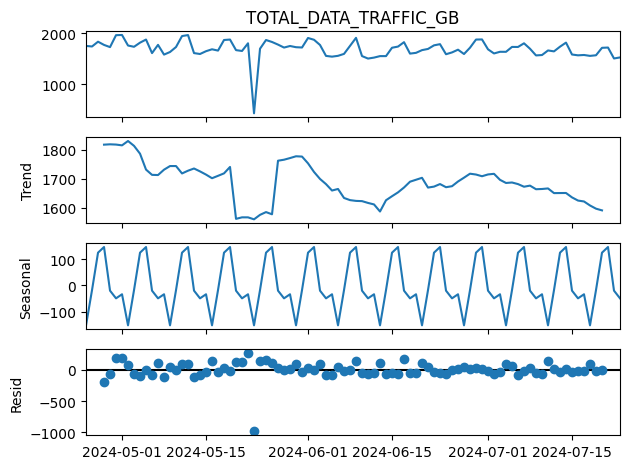

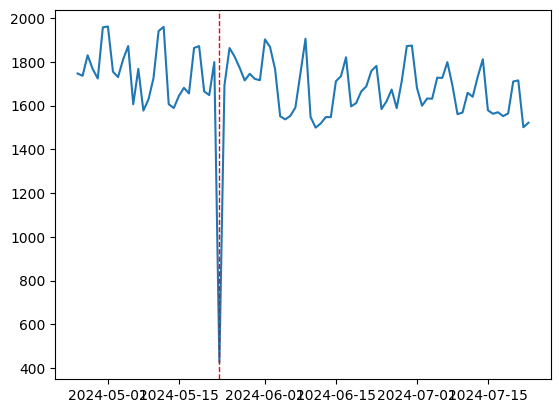

In [124]:
result = seasonal_decompose(df['TOTAL_DATA_TRAFFIC_GB'], model="additive")
result.plot()
visual_anormaly_range(result, df['TOTAL_DATA_TRAFFIC_GB'] , 0.01)

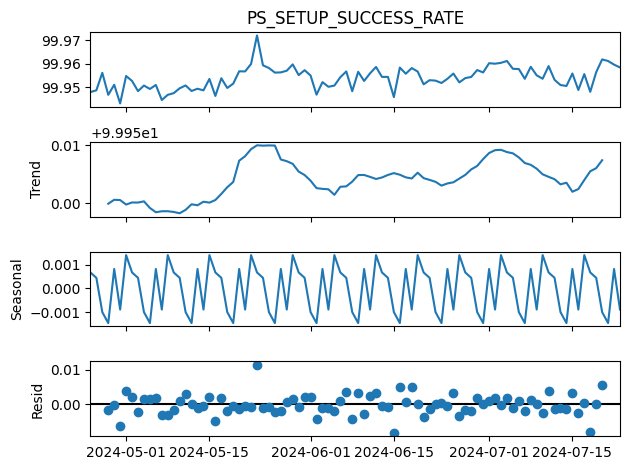

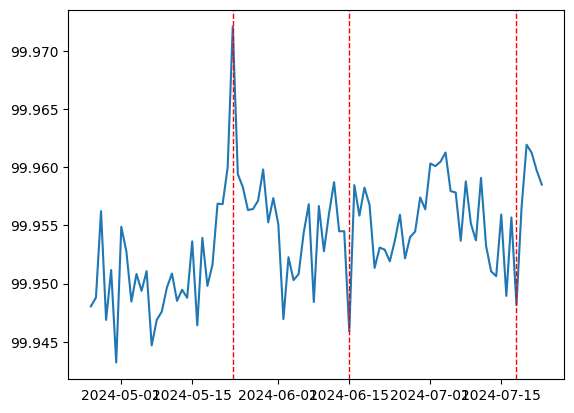

In [126]:
result = seasonal_decompose(df['PS_SETUP_SUCCESS_RATE'], model="additive")
result.plot()
visual_anormaly_range(result , df['PS_SETUP_SUCCESS_RATE'], 0.03)